In [8]:
import pandas as pd
import sys
import re
import os

import pathlib
import pickle
import string
import numpy as np

import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.corpus import stopwords

from sklearn.datasets import load_files
from sklearn.tree import DecisionTreeClassifier
import sklearn.metrics as metrics
from sklearn import model_selection, naive_bayes, svm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer as CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer as TfidfTransformer
from sklearn.pipeline import make_pipeline

import lime
import lime.lime_tabular
from lime import lime_text
from lime.lime_text import LimeTextExplainer

%matplotlib inline

<h2>1. Read the "raw" dataset</h2>

In [9]:
def get_articles() -> pd.DataFrame:
    """
    data is taken from: # data is taken from: https://github.com/katakonst/sentiment-analysis-tensorflow/tree/master/datasets
    :return: the dataset containing labeled articles
    """
    # define paths where text files were placed
    path = pathlib.Path('%s/sentiment-analysis-tensorflow-master/datasets/ro/train/' % os.environ['NLP_RO_DATA'])
    
    # load files
    data = load_files(path, encoding="utf-8", decode_error="replace", random_state=500)
        
    # remove newlines
    data['data'] = [it.lower().replace('\n\n', ' ') for it in data['data']]

    # convert dict to Pandas dataframe
    df_raw = pd.DataFrame(list(zip(data['data'], data['target'])), columns=['text', 'label'])
    
    # select only rows with non empty text
    df = df_raw[df_raw['text'] != '']
    
    return df

df_raw = get_articles()
df = df_raw.copy()
df_raw.head(10)

,text,label
0,acest film a fost cel mai rau film pe care l-a...,0
1,calitatea de nostri a lui foley in acest film ...,1
3,creativitatea acestui film a fost pierduta de ...,0
4,"cand am inchiriat acest lucru, speram ca ceea ...",0
5,acesta este un film de familie care incalzeste...,1
6,recomand\nraportul calitate-pret unul foarte bun,1
7,"acest film parea promitator, dar de fapt era d...",0
8,"este foarte amuzant. are o distributie mare, c...",1
9,"am jurat mult timp in urma ca niciodata, sa ma...",0
10,unul dintre filmele cele mai nihiliste si brut...,1


<h2>2. Pre-process dataset</h2>

<h3>2.1. Cleanup + Tokenization + Stemming</h3>

In [10]:
STOPWORDS = set(stopwords.words('romanian'))
PUNCTUATION_SIGNS = [c for c in string.punctuation] + ['``', "''", '...', '..']

# convert the labels from strings to binary values for our classifier
df['label'] = df.label.map({l: idx for idx, l in enumerate(set(df.label))})

# convert all characters to lower-case
df['text'] = df.text.map(lambda x: x.lower())

# remove new lines
df = df.replace('\n', ' ', regex=True)

# apply tokenization: divide a string into substrings by splitting on the specified string (defined in subclasses).
df['text'] = df['text'].apply(nltk.word_tokenize)

# remove non-alphanumeric words
df['text'] = df.text.map(lambda txt: [word for word in txt if word.isalpha()])

# remove stopwords + punctuation signs
df['text'] = df.text.map(lambda txt: [word.strip() for word in txt if word not in STOPWORDS])
df['text'] = df.text.map(lambda txt: [word.strip() for word in txt if word not in PUNCTUATION_SIGNS ])

# perform word stemming. The idea of stemming is to normalize our text to remove all variations of 
# words carrying the same meaning, regardless of the tense. 
# Porter Stemmer stemming algorithm is the most popular:
# https://www.nltk.org/_modules/nltk/stem/snowball.html
# http://snowball.tartarus.org/algorithms/romanian/stemmer.html
stemmer = SnowballStemmer(language="romanian")  # PorterStemmer()
df.head(10)

,text,label
0,"[film, rau, film, vazut, vreodata, misiune, do...",0
1,"[calitatea, foley, film, saturat, intens, celu...",1
3,"[creativitatea, film, pierduta, inceput, scrii...",0
4,"[inchiriat, lucru, speram, reign, of, fire, na...",0
5,"[film, familie, incalzeste, inima, absolut, st...",1
6,"[recomand, raportul, bun]",1
7,"[film, parea, promitator, fapt, destul, rau, p...",0
8,"[amuzant, distributie, mare, performante, groz...",1
9,"[jurat, timp, urma, niciodata, uit, vreodata, ...",0
10,"[filmele, nihiliste, brutale, vazut, vreodata,...",1


In [11]:
df['text'] = df['text'].apply(lambda x: [stemmer.stem(y.strip()) for y in x if y])
df.head(10)

,text,label
0,"[film, rau, film, vazut, vreodat, misiun, domi...",0
1,"[calitat, foley, film, satur, intens, celuloz,...",1
3,"[creativ, film, pierdut, incep, scriitor, regi...",0
4,"[inchir, lucru, sper, reign, of, fir, nast, ci...",0
5,"[film, famil, incalzest, inim, absol, straluc,...",1
6,"[recomand, raport, bun]",1
7,"[film, par, promit, fapt, dest, rau, premis, c...",0
8,"[amuz, distribut, mar, perform, grozav, ales, ...",1
9,"[jurat, timp, urma, niciod, uit, vreodat, film...",0
10,"[film, nihilist, brutal, vazut, vreodat, tragi...",1


In [12]:
print('There are {} labels with value {}'.format(df[df.label==0].shape[0], 0))
print('There are {} labels with value {}'.format(df[df.label==1].shape[0], 1))

There are 6827 labels with value 0
There are 10825 labels with value 1


<h3>2.2. Balance the dataset</h3>

In [13]:
positive_texts = df[df.label==1]
negative_texts = df[df.label==0]
df_preproc_balanced = pd.concat([positive_texts.sample(negative_texts.shape[0]), negative_texts], axis=0)

print('There are {} labels with value {}'.format(df_preproc_balanced[df_preproc_balanced.label==0].shape[0], 0))
print('There are {} labels with value {}'.format(df_preproc_balanced[df_preproc_balanced.label==1].shape[0], 1))

# show a sample of 10 values
df_preproc_balanced.sample(10)

There are 6827 labels with value 0
There are 6827 labels with value 1


,text,label
7388,"[multum, sper, prod, cumpar]",1
3023,"[florin, finaru, part, capac, locas, card, mic...",1
679,"[minun, imagin, b, minun, intampl, joe, lewis,...",1
11661,"[trebuit, uit, niciod, film, stil, film, consi...",0
9498,"[disney, intaln, film, putut, putin, dou, sequ...",0
3971,"[excelent, lei, noiembr, telefon, excelent, ec...",1
8091,"[apar, catev, lun, cred, plac, astept]",0
13294,"[telefon, exceptional, reusit, achizition, var...",1
4752,"[nemultum, chinezar, bater, slab, scoat, sunet...",0
9400,"[film, sti, vei, iub, prim, catev, secund, fil...",1


<h2>3. Scikit-learn based models</h2>

<h3>3.1. Define methods</h3>

In [7]:
def classify_dtree(x_test, x_train, y_test, y_train):
    # create Decision tree classifier
    model_dtree = DecisionTreeClassifier()
    
    # fit Decision tree classifier on training set
    model_dtree.fit(x_train, y_train)
    
    # predict on test dataset
    y_pred_dtree = model_dtree.predict(x_test)
    
    # Use 'accuracy_score()' function to compute the prediction accuracy
    _dtree_accuracy_score = metrics.accuracy_score(y_pred_dtree, y_test) * 100
    
    # compute classification report
    classification_report = metrics.classification_report(y_test, y_pred_dtree)
    
    return model_dtree, _dtree_accuracy_score, y_pred_dtree, classification_report


def classify_svc(x_test, x_train, y_test, y_train):
    # crate SVM classifier - 'linear' model performs better than 'rbf' model
    model_svc = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto', probability=False)
    
    # fit SVM classifier on training set
    model_svc.fit(x_train, y_train)
    
    # predict on test dataset
    y_pred_svc = model_svc.predict(x_test)
    
    # Use 'accuracy_score()' function to compute the prediction accuracy
    _svm_accuracy_score = metrics.accuracy_score(y_pred_svc, y_test) * 100
    
    # compute classification report
    classification_report = metrics.classification_report(y_test, y_pred_svc)
    
    return model_svc, _svm_accuracy_score, y_pred_svc, classification_report

def classify_logistic_regression(x_test, x_train, y_test, y_train):
    # crate Logistic Regression classifier
    model_lr = LogisticRegression()
    
    # fit classifier on training set
    model_lr.fit(x_train, y_train)
    
    # predict on test dataset
    y_pred_lr = model_lr.predict(x_test)
    
    # Use 'accuracy_score()' function to compute the prediction accuracy
    _lr_accuracy_score = metrics.accuracy_score(y_pred_lr, y_test) * 100
    
    # compute classification report
    classification_report = metrics.classification_report(y_test, y_pred_lr)
    
    return model_lr, _lr_accuracy_score, y_pred_lr, classification_report


def classify_bayes(x_test, x_train, y_test, y_train):
    # create Naive Bayes classifier
    # model_bayes = naive_bayes.MultinomialNB()  # the algorithm assumes that the features are drawn from a multinomial distribution
#     model_bayes = naive_bayes.GaussianNB()  # continuous values associated with each class are distributed according to a normal (or Gaussian) distribution
    model_bayes = naive_bayes.BernoulliNB()  # designed for binary/boolean features.
#     model_bayes = naive_bayes.ComplementNB()  # designed for imbalanced datasets
    
    # fit Bayesian classifier on training set
    model_bayes.fit(x_train, y_train)
    
    # predict on test dataset
    y_pred_bayes = model_bayes.predict(x_test)
    
    # compute accuracy score by using accuracy_score() function
    _bayes_accuracy_score = metrics.accuracy_score(y_pred_bayes, y_test) * 100
    
    # compute classification report
    classification_report = metrics.classification_report(y_test, y_pred_bayes)
    
    return model_bayes, _bayes_accuracy_score, y_pred_bayes, classification_report


def split_and_convert(_dataset, _test_size=0.2):

    # split the model into train and test datasets
    x_train_raw, x_test_raw, y_train_raw, y_test_raw = model_selection.train_test_split(_dataset['text'], _dataset['label'], test_size=_test_size)

    # encode (replace) text labels with numerical values between 0 and n_classes-1
    label_encoder = LabelEncoder()    

    # convert labels to digits
    y_train = label_encoder.fit_transform(y_train_raw)
    y_test = label_encoder.fit_transform(y_test_raw)

    # count words
    count_vectorizer = CountVectorizer()
    train_word_counts = count_vectorizer.fit_transform(x_train_raw)
    test_word_counts = count_vectorizer.transform(x_test_raw)

    # Transform x_train
    transformer = TfidfTransformer(use_idf=True).fit(train_word_counts)
    x_train_transformed = transformer.transform(train_word_counts)
    x_train = x_train_transformed.toarray()  # matrices should not be sparse (aka. dense) -> hence .toarray()

    # Transform x_test 
    x_test_transformed = transformer.transform(test_word_counts)
    x_test = x_test_transformed.toarray()  # matrices should not be sparse (aka. dense) -> hence .toarray()

    dataset_split = {'raw': {'x_train': x_train_raw, 'x_test': x_test_raw, 
                             'y_train': y_train_raw, 'y_test': y_test_raw},
                     'transformed': {'x_train': x_train, 'x_test': x_test, 
                                     'y_train': y_train, 'y_test': y_test}}
    
    return dataset_split, transformer, count_vectorizer


def truncate_dataset(dataset: pd.DataFrame, _max_words_per_document: int = 1000,
                     max_texts: int = 1000) -> pd.DataFrame:
    """
    This method does 2 things: 1. select a random sample from the dataset
                               2. reduce the amount of words in a document
    :param dataset: input dataset
    :param _max_words_per_document: the maximum allowed number of words per document
    :param max_texts: maximum allowed number of text from the dataset
    :return: the truncated version of the dataset
    """
#     print('Started truncating dataset')
    if _max_words_per_document:
        dataset['text'] = dataset['text'].apply(lambda x: ' '.join(x[0:_max_words_per_document]))
    else:
        dataset['text'] = dataset['text'].apply(lambda x: ' '.join(x))

    # select a random subset of the texts
    dataset = dataset.sample(max_texts)
#     print('Done truncating the dataset')
    
    return dataset

<h3>3.2. Run Experiments</h3>

In [10]:
%%time
def run(dataset: pd.DataFrame, test_size=0.2):
    """
    Do the actual training, fitting and testing of the models.
    :param dataset: input dataset
    :param test_size: how large the test is
    :return:
    """
    # train and split dataset into train and test parts
    dataset_split, transformer, count_vectorizer = split_and_convert(dataset, test_size)

    # group train/test datasets
    x_test, x_train, y_test, y_train = dataset_split['transformed']['x_test'], \
                                       dataset_split['transformed']['x_train'], \
                                       dataset_split['transformed']['y_test'], \
                                       dataset_split['transformed']['y_train']
    
    # 1. Bayes
    model_bayes, bayes_accuracy_score, y_pred_bayes, cl_report_bayes = classify_bayes(x_test, x_train, y_test, y_train)

    # 2. SVC
    model_svc, svc_accuracy_score, y_pred_svm, cl_report_svc = classify_svc(x_test, x_train, y_test, y_train)

    # 3. Decision Tree
    model_dtree, dtree_accuracy_score, y_pred_dtree, cl_report_dtree = classify_dtree(x_test, x_train, y_test, y_train)

    # 4. Logistic Regression
    model_lr, lr_accuracy_score, y_pred_lr, cl_report_lr = classify_logistic_regression(x_test, x_train, y_test, y_train)
    
    # group accuracy scores
    accuracy_scores = {'bayes': bayes_accuracy_score, 'svc': svc_accuracy_score, 'dtree': dtree_accuracy_score, 'lr': lr_accuracy_score}
    
    # group models
    models = {'bayes': model_bayes, 'svc': model_svc, 'dtree': model_dtree, 'lr': model_lr}
    
    # group classification reports
    classification_reports = {'bayes': cl_report_bayes, 'svc': cl_report_svc, 'dtree': cl_report_dtree, 'lr': cl_report_lr}
    
    return accuracy_scores, models, classification_reports, transformer, count_vectorizer, dataset_split

####################################################

results = pd.DataFrame(columns=['max_no_texts', 'classifier_type', 'exp_no', 'accuracy'])
repeats = 1
transformer = None

for dl in range(13653, 13654, 1):
    # repeat experiment for the same parameters a couple of times
    for exp_no in range(repeats):
        print('Dataset length {}, exp_no: {}'.format(dl, exp_no))
        truncated_dataset = truncate_dataset(dataset=df_preproc_balanced.copy(), max_texts=dl)
        
        # run an experiment
        accuracy_scores, models, classification_reports, \
        transformer, count_vectorizer, dataset_split = run(dataset=truncated_dataset, test_size=0.2)
        
        # store the results
        results = results.append({'max_no_texts': dl, 'classifier_type': 'bayes',
                                  'exp_no': exp_no, 'accuracy': accuracy_scores['bayes']}, ignore_index=True)

        results = results.append({'max_no_texts': dl, 'classifier_type': 'SVC',
                                  'exp_no': exp_no, 'accuracy': accuracy_scores['svc']}, ignore_index=True)

        results = results.append({'max_no_texts': dl, 'classifier_type': 'DTree',
                                  'exp_no': exp_no, 'accuracy': accuracy_scores['dtree']}, ignore_index=True)
        
        results = results.append({'max_no_texts': dl, 'classifier_type': 'LR',
                                  'exp_no': exp_no, 'accuracy': accuracy_scores['lr']}, ignore_index=True)

Dataset length 13653, exp_no: 0
CPU times: user 41min 27s, sys: 8.55 s, total: 41min 35s
Wall time: 41min 13s


<h3>3.3. Plot results</h3>

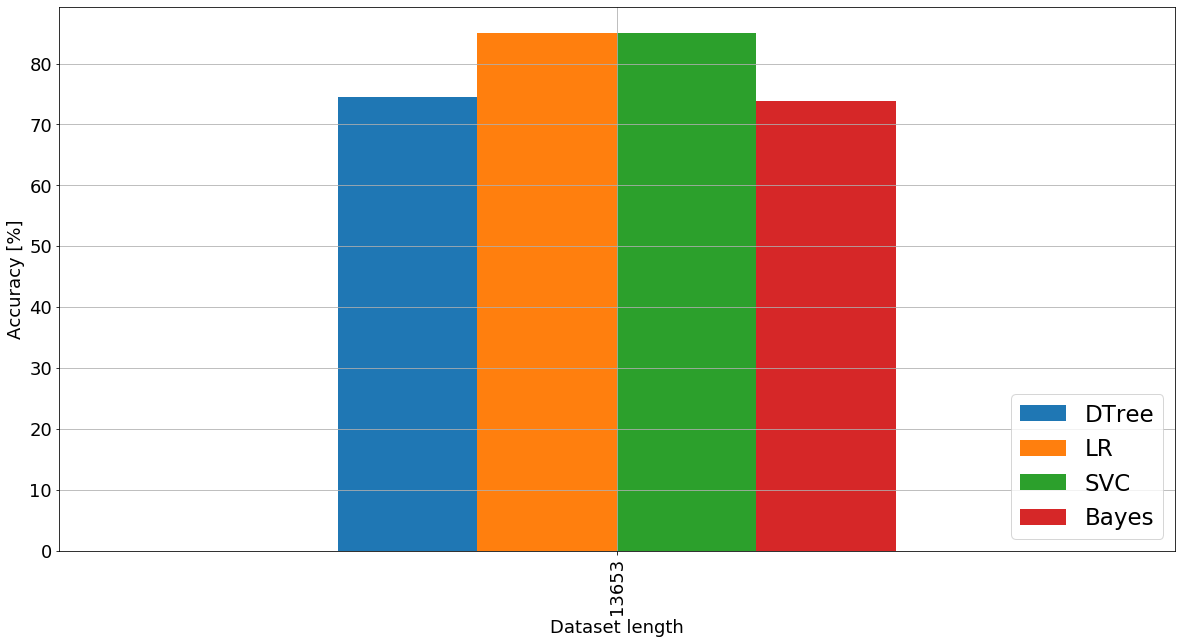

In [11]:
def plot_results(_results):
    plt.rcParams.update({'font.size': 18})
    fig, ax = plt.subplots(figsize=(20, 10))
    plt.rc('legend', fontsize=23, loc='lower right')

    # unstack the dataframe
    _results.groupby(['max_no_texts', 'classifier_type']).accuracy.agg(['median']).unstack().plot(ax=ax, grid=True, kind='bar')
    ax.legend(['DTree', 'LR', 'SVC', 'Bayes'])
    ax.set_xlabel('Dataset length', size=18)
    ax.set_ylabel('Accuracy [%]', size=18)

plot_results(results)

In [12]:
print('dataset shape: {}'.format(df_preproc_balanced.shape))
print('bayes: {}'.format(accuracy_scores['bayes']))
print('svc: {}'.format(accuracy_scores['svc']))
print('dtree: {}'.format(accuracy_scores['dtree']))
print('logistic regression: {}'.format(accuracy_scores['lr']))

dataset shape: (13654, 2)
bayes: 73.81911387770047
svc: 85.060417429513
dtree: 74.47821310875136
logistic regression: 85.060417429513


<h3>3.4. Test models</h3>

In [31]:
test_sample1 = 'Filmul este fantastic! Imi place foarte mult!'
test_sample2 = 'Filmul este groaznic! Nu l-as viziona!'
test_sample3 = 'Filmul este so-so. As merge mai degraba la teatru.'

data = {'text': [test_sample1, test_sample2, test_sample3], 'label': [-1, -1, -1]}
data_df = pd.DataFrame.from_dict(data)

counts = count_vectorizer.transform(data_df['text'])
text = transformer.transform(counts)

models['lr'].predict(text)

array([1, 0, 0])

<h3>3.5. Model accuracy stats</h3>

In [35]:
print(classification_reports['dtree'])
print(classification_reports['lr'])
print(classification_reports['svc'])
print(classification_reports['bayes'])

              precision    recall  f1-score   support

           0       0.75      0.73      0.74      1351
           1       0.74      0.76      0.75      1380

    accuracy                           0.74      2731
   macro avg       0.74      0.74      0.74      2731
weighted avg       0.74      0.74      0.74      2731

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1351
           1       0.86      0.85      0.85      1380

    accuracy                           0.85      2731
   macro avg       0.85      0.85      0.85      2731
weighted avg       0.85      0.85      0.85      2731

              precision    recall  f1-score   support

           0       0.86      0.84      0.85      1351
           1       0.85      0.86      0.85      1380

    accuracy                           0.85      2731
   macro avg       0.85      0.85      0.85      2731
weighted avg       0.85      0.85      0.85      2731

              preci

<h3>3.6. Explain the model</h3>

In [51]:
explained_model = models['lr']
idx = 11

c = make_pipeline(count_vectorizer, explained_model)

class_names=list(df_preproc_balanced.label.unique())
explainer = LimeTextExplainer(class_names=class_names)

# print(list(dataset_split['raw']['x_test'])[idx])
# print(list(dataset_split['raw']['y_test'])[idx])

exp = explainer.explain_instance(list(dataset_split['raw']['x_test'])[idx], c.predict_proba, num_features=10, labels=[0, 1])

print('Document id: %d' % idx)
print('Document text: %s' % list(dataset_split['raw']['x_test'])[idx])
print('True class: %s' % list(dataset_split['raw']['y_test'])[idx])
print('Predicted class: %d' % explained_model.predict(dataset_split['transformed']['x_test'])[idx])

print ('Explanations for class: %s' % list(dataset_split['raw']['y_test'])[idx])
print ('\n'.join(map(str, exp.as_list(label=list(dataset_split['raw']['y_test'])[idx]))))

/home/andrei/work/repos/github/datascience/venv/lib/python3.6/site-packages/lime/lime_text.py:116: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


Document id: 11
Document text: astaz vazut film mi- placut lum creat pur simplu extraordinar imagin ved cinem 3d imax lucr m-a impresion povest ok general mi-au placut anum moment alte putin per total mi- placut film recomand vad lum minun par real timp
True class: 1
Predicted class: 1
Explanations for class: 1
('placut', 0.01378709855431613)
('lum', 0.012687123392140088)
('minun', 0.012631616686001707)
('vazut', 0.010589176652991718)
('extraordinar', 0.008960931954320512)
('par', -0.00778420461172157)
('recomand', 0.007713920539033889)
('vad', 0.007595783852817189)
('timp', -0.006865655977861468)
('astaz', 0.006201770259938778)


<h2>4. NN-based classifier</h2>

In [14]:
# code inspired from: https://towardsdatascience.com/machine-learning-word-embedding-sentiment-classification-using-keras-b83c28087456
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, GRU
from tensorflow.keras.layers import Embedding, BatchNormalization
from tensorflow.keras.initializers import Constant
from tensorflow.keras import optimizers
from tensorflow.keras.models import model_from_json
import tensorflow

<h3>4.1. Learn word embedding</h3>

In [34]:
# join back words into strings
df_preproc_str = df_raw.copy()
df_preproc_str['text'] = df_preproc_str['text'].apply(lambda l: ' '.join(l))

In [35]:
# select a random subset of the texts
df_raw_sample = df_raw.copy()#sample(10000)

# split the model into train and test datasets
x_train, x_test, y_train, y_test = model_selection.train_test_split(df_raw_sample['text'], df_raw_sample['label'], test_size=0.2)

x_train = x_train.values
x_test = x_test.values

y_train = y_train.values
y_test = y_test.values

print(len(x_train) + len(x_test))

x_all = list(x_train) + list(x_test)

# define tokenizer object
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(x_all)

# store tokenizer obj to file
# code taken from: https://www.techcoil.com/blog/how-to-save-and-load-objects-to-and-from-file-in-python-via-facilities-from-the-pickle-module/
with open('tokenizer.obj', 'wb') as tokenizer_file:
    pickle.dump(tokenizer_obj, tokenizer_file)

# pad sequences
max_length = max([len(s.split()) for s in x_all])

print('max_length: {}'.format(max_length))

# define vocabulary size
vocab_size = len(tokenizer_obj.word_index) + 1

print('vocab_size: {}'.format(vocab_size))

x_train_tokens = tokenizer_obj.texts_to_sequences(x_train)
x_test_tokens = tokenizer_obj.texts_to_sequences(x_test)

x_train_pad = pad_sequences(x_train_tokens, maxlen=max_length, padding='post')
x_test_pad = pad_sequences(x_test_tokens, maxlen=max_length, padding='post')

17652
max_length: 373
vocab_size: 52890


<h3>4.2. Build Model</h3>

In [36]:
# check for nans: https://stackoverflow.com/questions/55051978/loss-of-cnn-in-keras-becomes-nan-at-some-point-of-training
EMBEDDING_DIM = 100

print('Started building model structure...')

rnn_model = Sequential()
rnn_model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=max_length))
rnn_model.add(GRU(units=64, dropout=0.1, recurrent_dropout=0.1))
rnn_model.add(BatchNormalization())
rnn_model.add(Dense(1, activation='sigmoid'))

_optimizer = optimizers.RMSprop(lr=0.01)

# try using different optimizers and fidderent optimizer configs
rnn_model.compile(loss='binary_crossentropy', optimizer=_optimizer,
              metrics=['accuracy'])

print('Done building model structure...')
print(rnn_model.summary())

Started building model structure...
Done building model structure...
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 373, 100)          5289000   
_________________________________________________________________
gru_4 (GRU)                  (None, 64)                31872     
_________________________________________________________________
batch_normalization_4 (Batch (None, 64)                256       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 5,321,193
Trainable params: 5,321,065
Non-trainable params: 128
_________________________________________________________________
None


<h3>4.3. Train Model</h3>

In [37]:
%%time
print('Started training the model...')
early_stopping = tensorflow.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
history = rnn_model.fit(x_train_pad, y_train, 
                        batch_size=32, 
                        epochs=100, 
                        validation_data=(x_test_pad, y_test), 
                        callbacks=[early_stopping],
                        verbose=2)
print('Done training the model...')

Started training the model...
Train on 14121 samples, validate on 3531 samples
Epoch 1/100
14121/14121 - 176s - loss: 0.6804 - accuracy: 0.5960 - val_loss: 0.7253 - val_accuracy: 0.3733
Epoch 2/100
14121/14121 - 159s - loss: 0.3754 - accuracy: 0.8225 - val_loss: 0.2723 - val_accuracy: 0.8901
Epoch 3/100
14121/14121 - 165s - loss: 0.1653 - accuracy: 0.9383 - val_loss: 0.2938 - val_accuracy: 0.8895
Epoch 4/100
14121/14121 - 149s - loss: 0.0984 - accuracy: 0.9670 - val_loss: 0.3261 - val_accuracy: 0.8929
Epoch 5/100
14121/14121 - 149s - loss: 0.0763 - accuracy: 0.9744 - val_loss: 0.4245 - val_accuracy: 0.8737
Epoch 6/100
14121/14121 - 142s - loss: 0.0635 - accuracy: 0.9793 - val_loss: 0.4261 - val_accuracy: 0.8765
Epoch 7/100
14121/14121 - 142s - loss: 0.0620 - accuracy: 0.9787 - val_loss: 0.4430 - val_accuracy: 0.8856
Epoch 8/100
14121/14121 - 142s - loss: 0.0605 - accuracy: 0.9813 - val_loss: 0.4060 - val_accuracy: 0.8726
Epoch 9/100
14121/14121 - 142s - loss: 0.0561 - accuracy: 0.9810 

<h3>4.4. Plot train history</h3>

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


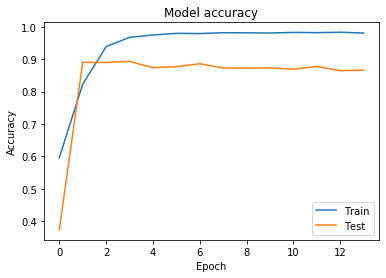

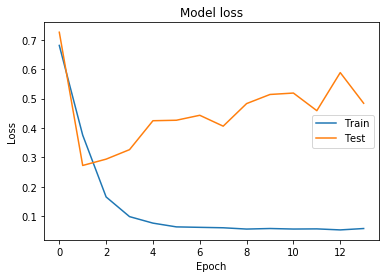

In [38]:
print(history.history.keys())

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='center right')
plt.show()

In [39]:
# Code inspired from: 
# - https://machinelearningmastery.com/save-load-keras-deep-learning-models/
def store_model(_model, path='./', file_prefix='model_sentiment_rnn'):
    
    # serialize model to JSON
    model_json = _model.to_json()
    json_file_path = os.path.join(path, "{}.json".format(file_prefix))
    print('Started saving model JSON to {}'.format(json_file_path))
    assert os.path.exists(path)
    with open(json_file_path, "w+") as json_file:
        json_file.write(model_json)
    print("Done saving model JSON to {}".format(json_file_path))
    
    # serialize weights to HDF5
    weights_file_path = os.path.join(path, '{}.h5'.format(file_prefix))
    print("Started saving model weights to {}".format(weights_file_path))
    _model.save_weights(weights_file_path)
    print("Done saving model weights to {}".format(weights_file_path))

def load_model(path='./', file_prefix='model_sentiment_rnn'):
    # load json and create model
    print('Started loading model from JSON file')
    with open('{}.json'.format(file_prefix), 'r') as json_file:
        loaded_model_json = json_file.read()
    loaded_model = model_from_json(loaded_model_json)
    print('Done loading model from JSON file')
    
    # load weights into new model
    print("Starting loading model from disk")
    weights_file_path = os.path.join(path, '{}.h5'.format(file_prefix))
    assert os.path.exists(weights_file_path)
    loaded_model.load_weights(weights_file_path)
    print("Done loading model from disk from file: {}".format(weights_file_path))
    return loaded_model

# save model:
store_model(rnn_model)
# model = load_model()
# print(model)

Started saving model JSON to ./model_sentiment_rnn.json
Done saving model JSON to ./model_sentiment_rnn.json
Started saving model weights to ./model_sentiment_rnn.h5
Done saving model weights to ./model_sentiment_rnn.h5


<h3>4.5. Test Model</h3>

In [40]:
test_sample1 = 'Filmul este fantastic! Imi place foarte mult!'
test_sample2 = 'Filmul este groaznic! Nu l-as viziona!'
test_sample3 = 'Filmul este so-so. As merge mai degraba la teatru.'
test_samples = [test_sample1, test_sample2, test_sample3]

test_samples_tokens = tokenizer_obj.texts_to_sequences(test_samples)
test_samples_tokens_pad = pad_sequences(test_samples_tokens, maxlen=max_length)

# predict
rnn_model.predict(x=test_samples_tokens_pad)

array([[0.99709034],
       [0.01067615],
       [0.7751931 ]], dtype=float32)

<h3>4.6. Train word2vec Embedding</h3>

In [41]:
# inspiration: https://towardsdatascience.com/machine-learning-word-embedding-sentiment-classification-using-keras-b83c28087456
import gensim

review_lines = list(df['text'])

# train word2vec model
gensim_model = gensim.models.Word2Vec(sentences=review_lines, size=EMBEDDING_DIM, window=5, workers=4, min_count=1)

# vocab size
words = list(gensim_model.wv.vocab)
print('Vocabulary size: %d' % len(words))

Vocabulary size: 29709


<h3>4.7. Test Word2Vec Model</h3>

In [42]:
gensim_model.wv.most_similar('politist')

[('interioar', 0.9962716102600098),
 ('betiv', 0.995508074760437),
 ('intalnest', 0.9940503239631653),
 ('portret', 0.9936536550521851),
 ('interconect', 0.9932307004928589),
 ('impotr', 0.9924734830856323),
 ('conflict', 0.9922173619270325),
 ('anchet', 0.9921332597732544),
 ('centrat', 0.992021918296814),
 ('leag', 0.991718053817749)]

In [43]:
# odd word out
print(gensim_model.wv.doesnt_match("rebel impotr protagonist copac".split()))

copac


/home/andrei/work/repos/github/datascience/venv/lib/python3.6/site-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)
